信用风险计量体系包括主体评级模型和债项评级两部分。主体评级和债项评级均有一系列评级模型组成，其中：

    主体评级模型可用「四张卡」来表示，分别是 A 卡、B 卡、C 卡和 F 卡；
    
    债项评级模型通常按照主体的融资用途，分为企业融资模型、现金流融资模型和项目融资模型等。

- A 卡：又称为申请者评级模型，主要应用于相关融资类业务中新用户的主体评级，适用于个人和机构融资主体。
- B 卡：又称为行为评级模型，主要应用于相关融资类业务中存量客户在续存期内的管理，如对客户可能出现的逾期、延期等行为进行预测，仅适用于个人融资主体。
- C 卡：又称为催收评级模型，主要应用于相关融资类业务中存量客户是否需要催收的预测管理，仅适用于个人融资主体。
- F 卡：又称为欺诈评级模型，主要应用于相关融资类业务中新客户可能存在的欺诈行为的预测管理，适用于个人和机构融资主体。

本次项目主要为申请者评分模型的开发过程。

In [1]:
import pandas as pd
import numpy as np 

## 定义观察时间窗口

In [2]:
#导入用户逾期的详情表
sample_window=pd.read_csv("./data/CreditSampleWindow.csv",encoding='utf8')

In [3]:
print(sample_window.columns.values)

['CID' 'STAGE_BEF' 'STAGE_AFT' 'START_DATE' 'CLOSE_DATE']


In [4]:
sample_window.shape

(1813157, 5)

In [5]:
sample_window.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813157 entries, 0 to 1813156
Data columns (total 5 columns):
CID           object
STAGE_BEF     object
STAGE_AFT     object
START_DATE    float64
CLOSE_DATE    float64
dtypes: float64(2), object(3)
memory usage: 69.2+ MB


In [6]:
sample_window.head(5)

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE
0,CID0128273,,M0,20170701.0,20170703.0
1,CID0214787,,M0,20180201.0,20180204.0
2,CID0287932,M4,M5,20180501.0,20180531.0
3,CID0351850,,M0,20161002.0,20161005.0
4,CID0217310,,M0,20150601.0,20150602.0


In [7]:
# 查看缺失值情况
sample_window.isnull().mean()

CID           0.000000
STAGE_BEF     0.082451
STAGE_AFT     0.082451
START_DATE    0.082451
CLOSE_DATE    0.082451
dtype: float64

In [8]:
#去除重复行
sample_window.drop_duplicates(inplace=True)

In [9]:
# 去除没有逾期阶段记录的信息
sample_window.dropna(subset=['STAGE_BEF','STAGE_AFT'], inplace=True)

In [10]:
sample_window.shape

(1663660, 5)

In [11]:
#取出每个用户，每个月份内的最高逾期记录作为该月份的逾期指标
sample_window.START_DATE=sample_window.START_DATE.apply(lambda x : int(x//100))
sample_window.CLOSE_DATE=sample_window.CLOSE_DATE.apply(lambda x : int(x//100))

In [12]:
sample_window["AFT_FLAG"] = sample_window.STAGE_AFT.apply(lambda x: int(x[-1]))

In [13]:
sample_window.START_DATE.value_counts(sort=False,dropna=False).head()

201802     84631
201803    114688
201801     88972
201804     89660
201805     98699
Name: START_DATE, dtype: int64

In [14]:
sample_window.CLOSE_DATE.value_counts(sort=False,dropna=False).head()

0          28364
201802     82058
201803    113132
201801     86811
201804     87754
Name: CLOSE_DATE, dtype: int64

In [15]:
# 将 CLOSE_DATE 为空的数据填补为 201805。（根据数据缺失的业务背景确定）
sample_window.loc[sample_window.CLOSE_DATE == 0,"CLOSE_DATE"] = 201805

In [16]:
sample_window.head()

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE,AFT_FLAG
0,CID0128273,,M0,201707,201707,0
1,CID0214787,,M0,201802,201802,0
2,CID0287932,M4,M5,201805,201805,5
3,CID0351850,,M0,201610,201610,0
4,CID0217310,,M0,201506,201506,0


In [17]:
#生成单个订单的流水
#ID、月份、月份对应的状态
overdue=sample_window.loc[:,["CID",'START_DATE','AFT_FLAG']]\
                .rename(columns={'START_DATE':'CLOSE_DATE'})\
                .append(sample_window.loc[:,["CID",'CLOSE_DATE','AFT_FLAG']],ignore_index=True)

In [18]:
#生成每个用户的逾期信息
overdue = overdue.pivot_table(columns='CLOSE_DATE',index='CID',values='AFT_FLAG',aggfunc='max')

- 构建转移概率矩阵

In [19]:
sample_window.AFT_FLAG.value_counts()

0    1107267
1     373910
2      40034
3      30199
4      25442
5      20923
6      20575
7      18326
8      14387
9      12597
Name: AFT_FLAG, dtype: int64

In [20]:
import collections     #导入包准备做计数字典

def get_mat(df):
    """
    构建转移矩阵，索引表示转移前的逾期状态，
    列名表示转移后的逾期状态。
    """
    trans_mat = pd.DataFrame(data=0,
                             columns=range(0,10),
                             index=range(0,10))
    counter = collections.Counter()               # 形成字典来进行计数，关键字是坐标形成的元祖，值为频数
    for i,j in zip(df.columns,df.columns[1:]):
        select = (df[i].notnull()) & (df[j].notnull())
        counter += collections.Counter(tuple(x) for x in df.loc[select, [i,j]].values)
        
    for key in counter.keys():
        trans_mat.loc[key[0],key[1]] = counter[key]
        
    trans_mat["all_count"] = trans_mat.apply(sum, axis=1)
    bad_count = []
    for j in range(10):
        bad_count.append(trans_mat.iloc[j,j+1:10].sum())
    trans_mat["bad_count"] = bad_count
    trans_mat["to_bad"] = trans_mat["bad_count"]/trans_mat["all_count"]
    return trans_mat
get_mat(overdue)

,0,1,2,3,4,5,6,7,8,9,all_count,bad_count,to_bad
0,218269,78639,3232,0,0,0,0,0,2,2,300144,81875,0.272786
1,59218,169811,20351,9020,0,16,8,8,2,6,258440,29411,0.113802
2,556,4061,3775,17287,7,0,0,0,0,0,25686,17294,0.673285
3,184,1233,586,1686,22226,446,0,0,0,2,26363,22674,0.860069
4,1,20,5,0,233,13634,2803,8,0,0,16704,16445,0.984495
5,0,2,2,0,0,211,14936,911,0,0,16062,15847,0.986614
6,0,0,0,2,0,0,179,17223,9,8,17421,17240,0.989610
7,0,8,0,0,8,0,8,1292,14262,4,15582,14266,0.915544
8,2,2,0,0,0,0,2,4,98,12527,12635,12527,0.991452
9,0,10,2,4,0,4,8,12,22,247,309,0,0.000000


由上表可知，在逾期阶段到了 M2 时，下一阶段继续转坏的概率达到了 67%，逾期阶段到达 M3 阶段时，下一阶段继续转坏的概率为 86%，暂定M2为时间窗口表现内容。

## 定义表现时间窗口

In [21]:
#收集是否触发变坏样本，所定义的时间窗口

In [22]:
#读取订单首次的日期信息表
first_use=pd.read_csv("./data/CreditFirstUse.csv",encoding='utf8')

In [23]:
first_use.head()

,CID,FST_USE_DT
0,CID0092102,20161116
1,CID0111878,20161118
2,CID0264977,20161120
3,CID0059996,20160907
4,CID0057096,20160910


In [24]:
first_use.set_index('CID',inplace=True)

In [25]:
first_use["FST_USE_MONTH"] = first_use.FST_USE_DT.map(lambda x:x//100)

In [26]:
first_use.head()

,FST_USE_DT,FST_USE_MONTH
CID,,
CID0092102,20161116,201611
CID0111878,20161118,201611
CID0264977,20161120,201611
CID0059996,20160907,201609
CID0057096,20160910,201609


In [27]:
# 计算每笔订单第一次出现逾期的月份索引位置
def get_first_overdue(ser):
    array = np.where(ser>= 2)[0]
    if array.size > 0:
        return array[0]
    else:
        return np.nan

In [28]:
OVERDUE_INDEX = overdue.apply(get_first_overdue,axis=1)

In [29]:
first_use["OVERDUE_INDEX"] = OVERDUE_INDEX

In [30]:
first_use["START_INDEX"] = first_use.FST_USE_MONTH.map({k:v for v,k in enumerate(overdue.columns)}) 
# 为了和overdue_index表示记录上的一致性，将月份转换为数字记录的形式（字典映射）

In [31]:
first_use.loc[first_use.OVERDUE_INDEX.notnull()].head()

,FST_USE_DT,FST_USE_MONTH,OVERDUE_INDEX,START_INDEX
CID,,,,
CID0082006,20160906,201609,26.0,18.0
CID0383647,20160906,201609,29.0,18.0
CID0006192,20161022,201610,28.0,19.0
CID0348120,20161122,201611,33.0,20.0
CID0155834,20161123,201611,28.0,20.0


In [32]:
# 查看异常数据
first_use[first_use.OVERDUE_INDEX < first_use.START_INDEX]

,FST_USE_DT,FST_USE_MONTH,OVERDUE_INDEX,START_INDEX
CID,,,,
CID0164451,20170722,201707,9.0,28.0


In [33]:
sample_window.loc[sample_window.CID=="CID0164451",:]

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE,AFT_FLAG
1115857,CID0164451,M1,M2,201512,201512,2
1298974,CID0164451,,M0,201511,201511,0
1462710,CID0164451,M0,M1,201511,201512,1
1796143,CID0164451,,M0,201701,201701,0


In [34]:
# 仅有一条处理时删除即可(该方法比直接删除好的地方在于同时还得到了统计数字)
month_count = (first_use.OVERDUE_INDEX - first_use.START_INDEX).value_counts().sort_index()[1:]
#从开始距离第一次变坏间隔了多少个月的统计数字

In [35]:
month_count.describe()

count      38.000000
mean      816.868421
std       628.975536
min         1.000000
25%       269.000000
50%       604.500000
75%      1333.000000
max      2039.000000
dtype: float64

In [36]:
month_count.plot()

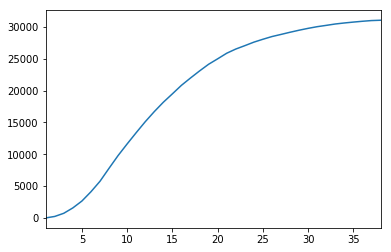

In [37]:
month_count.cumsum().plot()

## 数据准备与数据预处理

In [38]:
#读取用户申请信息表数据
train_data=pd.read_csv("./data/cs-training.csv",index_col=0)

In [39]:
train_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [40]:
train_data.tail()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0
150000,0,0.850283,64,0,0.249908,8158.0,8,0,2,0,0.0


In [41]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [42]:
#查看数据分布
train_data.describe([0.01,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.0,0.002969,0.029867,0.154181,0.559046,0.981278,1.092956,50708.0
age,150000.0,52.295207,14.771866,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.0,0.030874,0.175074,0.366508,0.868254,1267.000000,4979.040000,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,0.0,2005.000000,3400.000000,5400.000000,8249.000000,11666.000000,25000.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


### 缺失值处理

In [43]:
#查看缺失值
train_data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

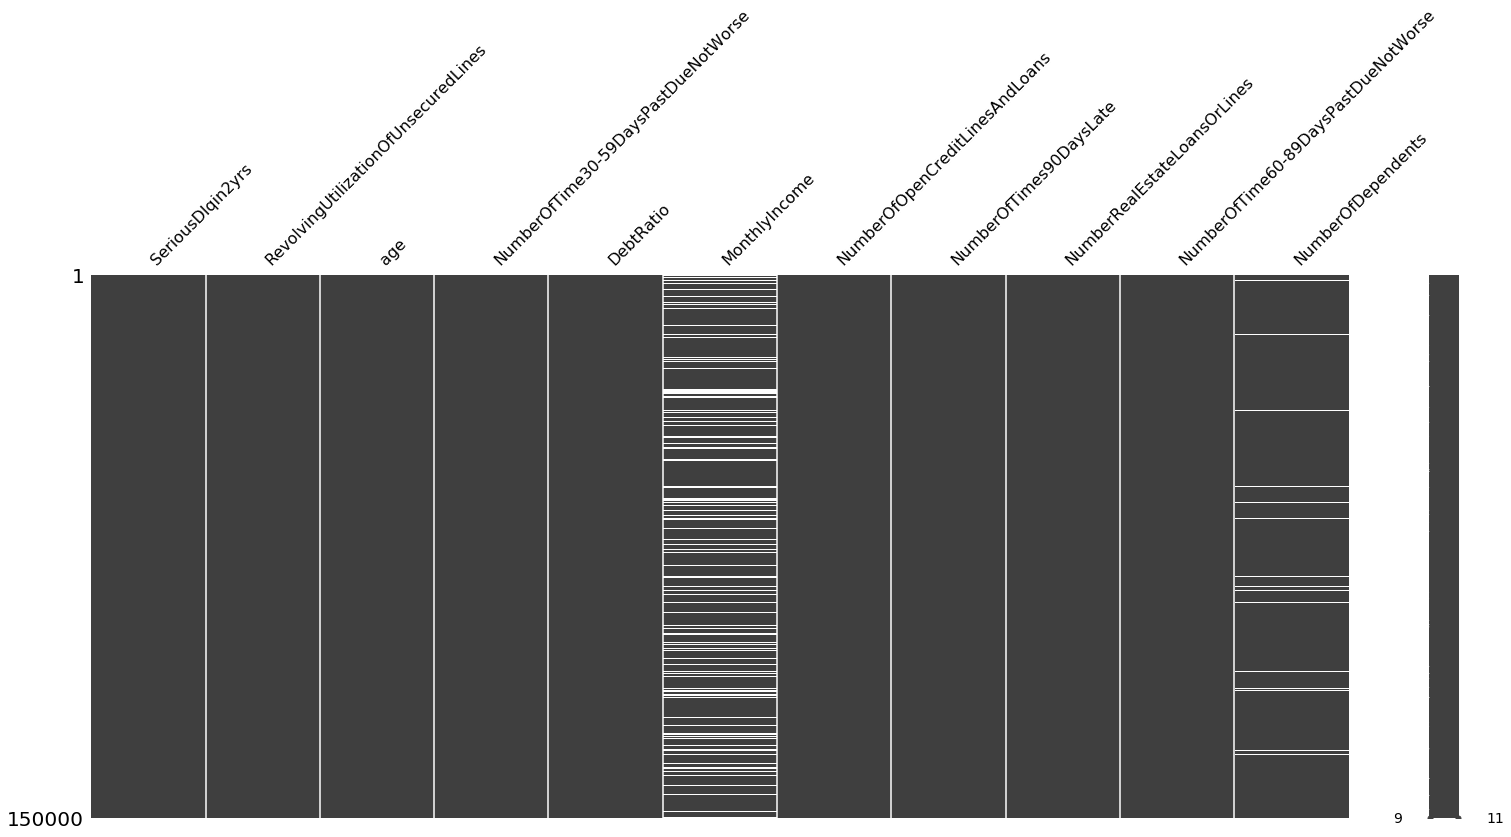

In [44]:
#较好的可视化缺失值状况分析
import missingno as msno
msno.matrix(train_data)

In [45]:
#一个人的收入与其自身的行为特征有较大可能的关联，所以我计划，使用随机森林算法进行缺失值填补
from sklearn.ensemble import RandomForestRegressor as rfr

In [46]:
def fill_missing(data,to_fill):
    df=data.copy()
    columns=[*df.columns]
    columns.remove(to_fill)
    columns.remove("NumberOfDependents")
    x=df.loc[:,columns]
    y=df.loc[:,to_fill]
    x_train=x.loc[df[to_fill].notnull()]
    x_pred=x.loc[df[to_fill].isnull()]
    y_train=y.loc[df[to_fill].notnull()]
    model=rfr(random_state=0,
              n_estimators=200,
              max_depth=3,
              n_jobs=-1)
    model.fit(x_train,y_train)
    pred=model.predict(x_pred)
    df.loc[df[to_fill].isnull(),to_fill]=pred
    return df

In [47]:
train_data=fill_missing(train_data,'MonthlyIncome')

In [48]:
#因为NumberOfDependents 缺失值仅有2.6%，比较少，可以考虑直接删除
train_data.dropna(inplace=True)

### 异常值处理

In [49]:
train_data.age.value_counts().sort_index()

0         1
21      152
22      396
23      599
24      760
25      909
26     1148
27     1282
28     1520
29     1663
30     1898
31     2016
32     2024
33     2220
34     2123
35     2214
36     2343
37     2489
38     2599
39     2965
40     3059
41     3094
42     3056
43     3185
44     3274
45     3470
46     3660
47     3671
48     3741
49     3782
       ... 
74     1379
75     1168
76     1114
77     1032
78      990
79      915
80      822
81      712
82      598
83      463
84      439
85      435
86      367
87      310
88      265
89      242
90      167
91      129
92       82
93       70
94       35
95       37
96       14
97       12
98        5
99        5
101       3
102       3
103       3
107       1
Name: age, Length: 84, dtype: int64

In [50]:
#可视化查看异常值
import matplotlib.pyplot as plt

In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146076 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        146076 non-null int64
RevolvingUtilizationOfUnsecuredLines    146076 non-null float64
age                                     146076 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    146076 non-null int64
DebtRatio                               146076 non-null float64
MonthlyIncome                           146076 non-null float64
NumberOfOpenCreditLinesAndLoans         146076 non-null int64
NumberOfTimes90DaysLate                 146076 non-null int64
NumberRealEstateLoansOrLines            146076 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    146076 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.4 MB


In [52]:
col=["age","NumberOfTime30-59DaysPastDueNotWorse","NumberOfTime60-89DaysPastDueNotWorse","NumberOfTimes90DaysLate"]

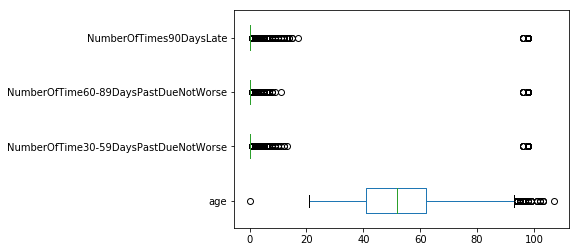

In [53]:
train_data[col].plot.box(vert=False)

In [54]:
train_data=train_data.loc[train_data.age>0]

In [55]:
#从业务上考虑，后面三个特征不应出现高的次数，可以删除异常数据
for i in col[1:]:
    train_data=train_data.loc[train_data[i]<90]

In [56]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145837 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        145837 non-null int64
RevolvingUtilizationOfUnsecuredLines    145837 non-null float64
age                                     145837 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    145837 non-null int64
DebtRatio                               145837 non-null float64
MonthlyIncome                           145837 non-null float64
NumberOfOpenCreditLinesAndLoans         145837 non-null int64
NumberOfTimes90DaysLate                 145837 non-null int64
NumberRealEstateLoansOrLines            145837 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    145837 non-null int64
NumberOfDependents                      145837 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.4 MB


### 数据集的划分

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
Y=train_data['SeriousDlqin2yrs']
X=train_data.iloc[:,1:]

In [59]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3)

In [60]:
model_data=pd.concat([Y_train,X_train],axis=1)
test_data=pd.concat([Y_test,X_test],axis=1)

### 探索性数据分析

In [61]:
 model_data["SeriousDlqin2yrs"].value_counts()

0    95365
1     6720
Name: SeriousDlqin2yrs, dtype: int64

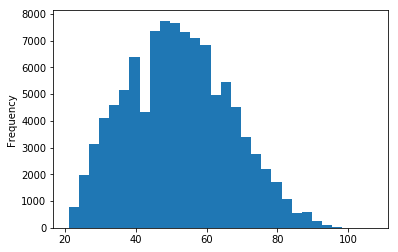

In [62]:
 model_data["age"].plot.hist(bins=30);

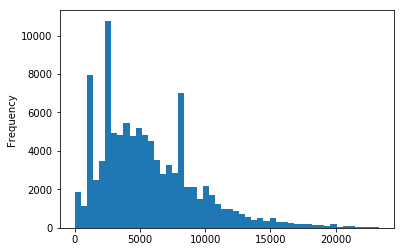

In [63]:
# 可以看出收入有少部分人非常高，使用小于 99% 的分位数的数据查看收入分布
income = model_data["MonthlyIncome"]
income.loc[income < 23334].plot.hist(bins=50);

In [64]:
#绘制变量关系的相关关系矩阵
model_data.corr()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.000894,-0.109923,0.266950,-0.007266,-0.015567,-0.029686,0.309250,-0.007811,0.264013,0.047168
RevolvingUtilizationOfUnsecuredLines,-0.000894,1.000000,-0.004131,-0.002976,0.003854,0.006426,-0.011448,-0.000555,0.004158,-0.001671,0.003053
age,-0.109923,-0.004131,1.000000,-0.070216,0.025885,0.020299,0.156588,-0.083444,0.039355,-0.069874,-0.213723
NumberOfTime30-59DaysPastDueNotWorse,0.266950,-0.002976,-0.070216,1.000000,0.004221,0.002883,0.074816,0.208516,0.040883,0.299790,0.063132
DebtRatio,-0.007266,0.003854,0.025885,0.004221,1.000000,-0.014614,0.050245,-0.010560,0.117168,-0.002387,-0.043852
MonthlyIncome,-0.015567,0.006426,0.020299,0.002883,-0.014614,1.000000,0.095778,-0.018911,0.130303,-0.009810,0.072767
NumberOfOpenCreditLinesAndLoans,-0.029686,-0.011448,0.156588,0.074816,0.050245,0.095778,1.000000,-0.099074,0.431954,-0.026994,0.065797
NumberOfTimes90DaysLate,0.309250,-0.000555,-0.083444,0.208516,-0.010560,-0.018911,-0.099074,1.000000,-0.063521,0.284752,0.033244
NumberRealEstateLoansOrLines,-0.007811,0.004158,0.039355,0.040883,0.117168,0.130303,0.431954,-0.063521,1.000000,-0.021683,0.125842
NumberOfTime60-89DaysPastDueNotWorse,0.264013,-0.001671,-0.069874,0.299790,-0.002387,-0.009810,-0.026994,0.284752,-0.021683,1.000000,0.039002


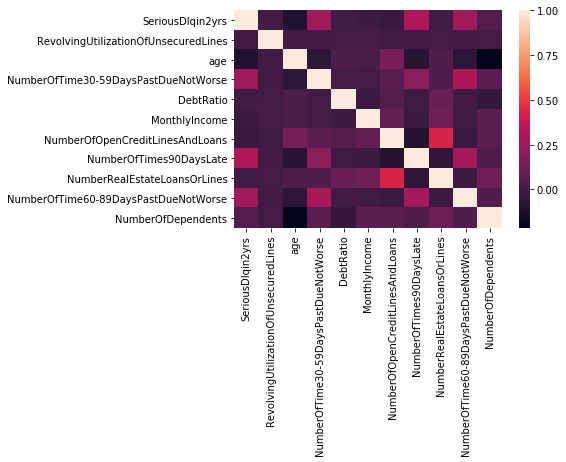

In [65]:
import seaborn
seaborn.heatmap(model_data.corr());

## 变量选择

### 对数据进行自动分箱

In [66]:
# 导入做好的分箱包
from auto_bin import AutoBins

In [67]:
bins_data = AutoBins(model_data, "SeriousDlqin2yrs")

In [68]:
auto_bins_columns=[]
for i in model_data.columns:
    if model_data[i].value_counts().count()>20:
        auto_bins_columns.append(i)

In [69]:
total_bins={}
total_bins['num_bins']={}
total_bins['woe_df']={}
total_bins['iv']={}
for i in auto_bins_columns:
    num_bins, woe_df, iv = bins_data.auto_bins(i,n=2)   
    total_bins['num_bins'][i]=[x[0] for x in num_bins] + [float("inf")]
    total_bins['woe_df'][i]=woe_df
    total_bins['iv'][i]=iv

对 RevolvingUtilizationOfUnsecuredLines 列进行分箱: 
分组个数: 03 	iv值: 1.0104046333992556
woe情况:
         min       max  count_0  count_1  total  percentage  bad_rate       woe
0      -inf  0.117146    45115      823  45938    0.449998  0.017915  1.351390
1  0.117146  0.698626    33821     1909  35730    0.350002  0.053428  0.221879
2  0.698626       inf    16429     3988  20417    0.200000  0.195327 -1.236865
对 age 列进行分箱: 
分组个数: 06 	iv值: 0.23811535853297242
woe情况:
     min   max  count_0  count_1  total  percentage  bad_rate       woe
0  -inf  36.0    14435     1727  16162    0.158319  0.106856 -0.529353
1  36.0  46.0    19811     1841  21652    0.212098  0.085027 -0.276695
2  46.0  56.0    23313     1795  25108    0.245952  0.071491 -0.088617
3  56.0  62.0    13299      668  13967    0.136817  0.047827  0.338532
4  62.0  68.0    10817      369  11186    0.109575  0.032988  0.725454
5  68.0   inf    13690      320  14010    0.137239  0.022841  1.103476
对 DebtRatio 列进行分箱: 
分组个数: 04 	iv值: 0.0540

### 对数据手动分箱

In [70]:
# 添加手动分箱列
for i in model_data.columns[1:]:
    if model_data[i].value_counts().count()<=20:
        print(model_data[i].value_counts())

0     85814
1     11041
2      3148
3      1205
4       490
5       236
6        88
7        34
8        18
9         6
10        2
13        1
12        1
11        1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64
0     96569
1      3627
2      1031
3       451
4       192
5        93
6        57
7        24
9        13
8        13
10        5
11        4
15        2
12        2
14        1
13        1
Name: NumberOfTimes90DaysLate, dtype: int64
0    97116
1     3888
2      762
3      211
4       70
5       18
6       12
7        5
8        2
9        1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64
0.0     60582
1.0     18495
2.0     13656
3.0      6682
4.0      1978
5.0       515
6.0       119
7.0        32
8.0        19
9.0         4
13.0        1
20.0        1
10.0        1
Name: NumberOfDependents, dtype: int64


In [71]:
hand_bins={'NumberOfTime30-59DaysPastDueNotWorse':[0,1,2,13],
          'NumberOfTimes90DaysLate':[0,1,2,17],
          'NumberOfTime60-89DaysPastDueNotWorse':[0,1,2,9],
          'NumberOfDependents':[0,1,2,3,10]}
hand_bins={k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

### 合并数据并且对数据进行iv值计算

In [72]:
total_bins['num_bins'].update(hand_bins)

In [73]:
#计算分箱数据的IV值
def get_iv(df,col,y,bins):
    df=df[[col,y]].copy()
    df['cut']=pd.cut(df[col],bins)
    bins_df=df.groupby('cut')[y].value_counts().unstack()
    bins_df['woe']=np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    iv=np.sum((bins_df[0]/bins_df[0].sum()-bins_df[1]/bins_df[1].sum())*bins_df.woe)
    return iv,bins_df

In [74]:
#保存IV值信息
iv_values={}
#保存woe信息
woe_values={}
for col in total_bins['num_bins']:
    iv_woe=get_iv(model_data,col,'SeriousDlqin2yrs',total_bins['num_bins'][col])
    iv_values[col],woe_values[col]=iv_woe

### 条形图筛选合适的特征

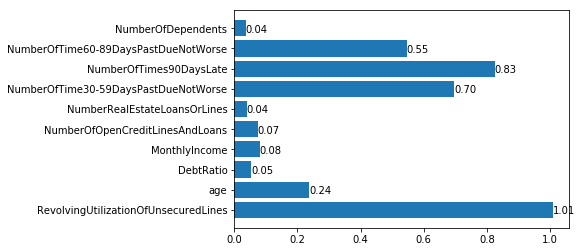

In [75]:
# 画出条形图标明iv值
def plt_iv(info_values):
    keys,values = zip(*info_values.items())
    nums = range(len(keys))
    plt.barh(nums,values)
    plt.yticks(nums,keys)
    for i, v in enumerate(values):
        plt.text(v, i-.2, f"{v:.2f}")
plt_iv(iv_values)

DebtRtion,NumberRealEstateLoansOrLines,NumberOfDependentsiv值太低，考虑删除

## 模型构建

### WOE 转换

通过生成的分箱和 WOE 数据

In [76]:
model_woe = pd.DataFrame(index=model_data.index)

In [77]:
for col in total_bins['num_bins']:
    model_woe[col]=pd.cut(model_data[col],total_bins['num_bins'][col]).map(woe_values[col]['woe'])

In [78]:
model_woe['SeriousDlqin2yrs']=model_data["SeriousDlqin2yrs"]

In [79]:
model_woe.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
59896,0.221879,-0.276695,0.083101,-0.018853,0.329915,0.166318,0.516533,0.369807,0.266907,0.157753,0
37225,1.351390,-0.276695,0.083101,-0.018853,-0.099079,0.166318,0.516533,0.369807,0.266907,0.157753,0
70298,1.351390,-0.529353,0.083101,-0.332918,0.157408,0.166318,0.516533,0.369807,0.266907,0.157753,0
87486,1.351390,-0.276695,0.083101,-0.018853,0.168192,0.166318,0.516533,0.369807,0.266907,-0.106217,0
103017,-1.236865,-0.088617,0.108522,-0.018853,0.120690,0.166318,-1.640264,-1.960717,-3.013868,0.157753,1


### logistic模型建立

In [80]:
import statsmodels.api as sm

In [81]:
Y = model_woe['SeriousDlqin2yrs']

In [82]:
X = model_woe.drop(["DebtRatio",
                    "NumberRealEstateLoansOrLines",
                    "NumberOfDependents",
                    'SeriousDlqin2yrs'],axis=1)

In [83]:
x=sm.add_constant(X) # 将第一列添加到数据中

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [84]:
logit=sm.Logit(Y,x)
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.184126
         Iterations 8


In [85]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               102085
Model:                          Logit   Df Residuals:                   102077
Method:                           MLE   Df Model:                            7
Date:                Mon, 16 Sep 2019   Pseudo R-squ.:                  0.2414
Time:                        17:32:27   Log-Likelihood:                -18796.
converged:                       True   LL-Null:                       -24777.
                                        LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.6245      0.015   -172.086      0.000      -2.654      -2.595
RevolvingUtilizationOfUnsecuredLines    -0.6208      0.016    -39.718      0.000      -0.651      -0.590
age                                     -0.4572      0.033    -13.992      0.000      -0.521      -0.393
MonthlyIncome                           -0.4177      0.051     -8.168      0.000      -0.518      -0.317
NumberOfOpenCreditLinesAndLoans         -0.1139      0.051     -2.233      0.026      -0.214      -0.014
NumberOfTime30-59DaysPastDueNotWorse    -0.5646      0.016    -34.924      0.000      -0.596      -0.533
NumberOfTimes90DaysLate                 -0.5423      0.014    -38.888      0.000      -0.570      -0.515
NumberOfTime60-89DaysPastDueNotWorse    -0.4190      0.017    -24.145      0.000      -0.453      -0.385
========================================================================================================
"""

各变量已通过显著性检验

### 模型检验

In [86]:
test_woe=pd.DataFrame(index=test_data.index)

In [87]:
for col in total_bins['num_bins']:
    test_woe[col]=pd.cut(test_data[col],total_bins['num_bins'][col]).map(woe_values[col]['woe'])

In [88]:
test_woe['SeriousDlqin2yrs']=test_data['SeriousDlqin2yrs']

In [89]:
test_Y=test_woe['SeriousDlqin2yrs']

In [90]:
test_X=test_woe.drop(["DebtRatio",
                    "NumberRealEstateLoansOrLines",
                    "NumberOfDependents",
                    'SeriousDlqin2yrs'],axis=1)

In [91]:
test_x=sm.add_constant(test_X)

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [92]:
test_proba=result.predict(test_x)

In [93]:
# 画ROC曲线
import scikitplot as skplt

In [94]:
test_proba_df=pd.DataFrame(test_proba,columns=[1])

In [95]:
test_proba_df.insert(0,0,1-test_proba_df)

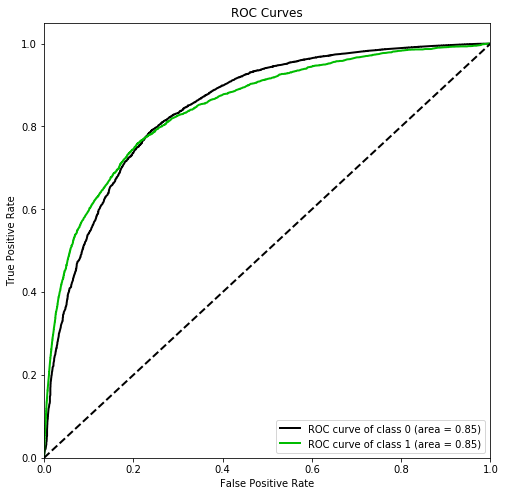

In [96]:
skplt.metrics.plot_roc(test_Y,test_proba_df,plot_macro=False,plot_micro=False,figsize=[8,8]);

## 信用评分

根据信用评分常用模型
$$Score = A − B × ln(odds)$$

假设比率为$\theta_0$ 的特定点的分值为$P_0$。则比率为$\theta_\frac{\theta}{2}$ 的点的分值应该为$P_0+PDO$:
$$P_0 = A − B × ln(\theta_0)$$
$$P_0 + PDO = A − B × ln(\theta_\frac{\theta}{2})$$

根据上述内容：
$$B = \frac{PDO}{ln(2)}$$
$$A = P_0 + B ∗ ln(2\theta_0)$$

假定比率$Odds$为$1 : 60$时设定的特定分数为$600$，$PDO=20$，那么比率为$1:120$时的分数为 $620$，代入以上线性表达式，可得:

In [97]:
B = 20/np.log(2)
A=600+B*np.log(1/60)
B,A

(28.85390081777927, 481.8621880878296)

In [98]:
result.params

const                                  -2.624464
RevolvingUtilizationOfUnsecuredLines   -0.620799
age                                    -0.457183
MonthlyIncome                          -0.417701
NumberOfOpenCreditLinesAndLoans        -0.113943
NumberOfTime30-59DaysPastDueNotWorse   -0.564632
NumberOfTimes90DaysLate                -0.542315
NumberOfTime60-89DaysPastDueNotWorse   -0.418977
dtype: float64

In [99]:
base_score = A - B*result.params["const"]

In [100]:
base_score

557.5882247504452

In [102]:
# 将评分卡写入文件
file = "ScoreData.csv"
with open(file,"w") as fdata:
    fdata.write(f"base_score,{base_score}\n")
for col in result.params.index[1:]:
    score = woe_values[col]["woe"] * (-B*result.params[col])
    score.name = "Score"
    score.index.name = col
    score.to_csv(file,header=True,mode="a")

对于一个新的客户判断方式，可以对其数据情况对应加分求和